In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 - Loss: 0.2118 - Accuracy: 0.9295
Epoch 2/3 - Loss: 0.0455 - Accuracy: 0.9941
Epoch 3/3 - Loss: 0.0217 - Accuracy: 0.9980


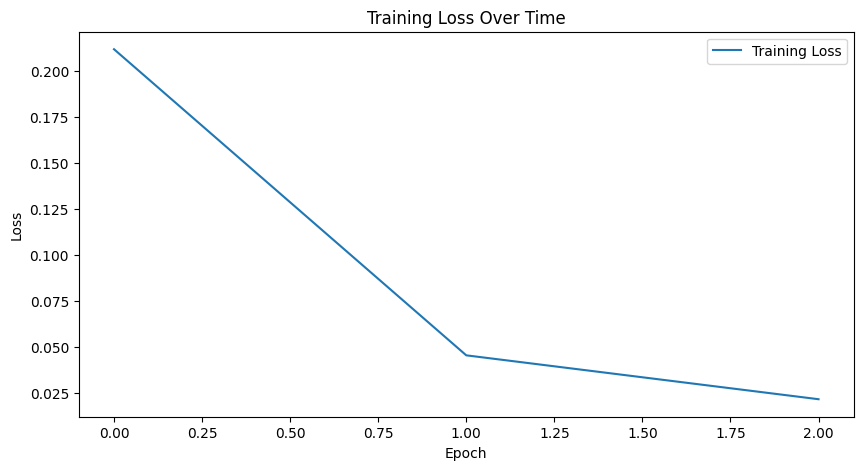

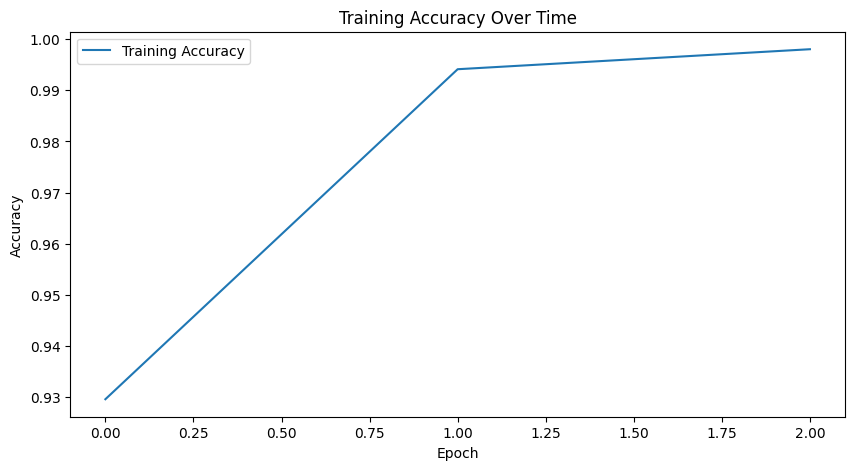

Model saved!
Testing Accuracy: 0.9977
Precision: 1.0000
Recall: 0.9583
F1 Score: 0.9787
AUC-ROC: 0.9792


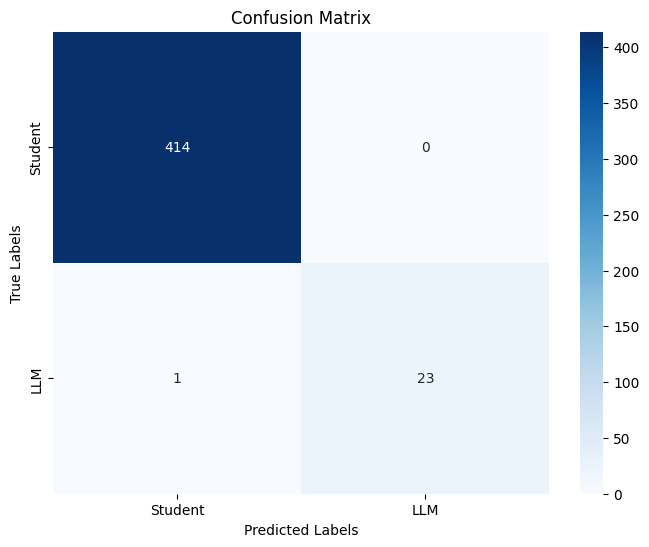

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
dat = pd.read_excel('/content/drive/MyDrive/Neural Net and Deep Learning Files/train_essays.xlsx')
dat = dat.iloc[0:1460]  # Select all samples

# Tokenize and encode the text data using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
encoded_data = tokenizer.batch_encode_plus(
    dat['text'].tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_mask = encoded_data['attention_mask']
labels = torch.tensor(dat['generated'].tolist())

# Split the data into training and testing sets (70-30 split)
train_inputs, test_inputs, train_masks, test_masks, train_labels, test_labels = train_test_split(
    input_ids, attention_mask, labels, random_state=42, test_size=0.3
)

# Create DataLoader for training and testing sets
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define BERT-based classification model
class BERTClassifier(nn.Module):
    def __init__(self):
        super(BERTClassifier, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return outputs.logits

# Instantiate the model and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier().to(device)

# Define the optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Lists to store training loss and accuracy for plotting
train_loss_list = []
train_accuracy_list = []

# Training the model
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.view(-1, 2), labels.view(-1))  # Binary classification loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted_labels = torch.max(outputs, 1)
        correct_predictions += torch.sum(predicted_labels == labels).item()

    # Calculate average training loss and accuracy for the epoch
    avg_loss = total_loss / len(train_dataloader)
    accuracy = correct_predictions / len(train_dataset)

    print(f'Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f}')

    # Store values for plotting
    train_loss_list.append(avg_loss)
    train_accuracy_list.append(accuracy)

# Plot training loss over time
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

# Plot training accuracy over time
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_list, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Time')
plt.legend()
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'bert_model.pth')
print("Model saved!")

# Evaluate the model
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted_labels = torch.max(outputs, 1)

        predictions.extend(predicted_labels.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
roc_auc = roc_auc_score(true_labels, predictions)

# Print metrics
print(f'Testing Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUC-ROC: {roc_auc:.4f}')

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Student', 'LLM'], yticklabels=['Student', 'LLM'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
